## Basic Naive Bayes and Improvement Analysis

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
%matplotlib inline


### Import and Primary Analysis

In [60]:
text_train = pd.read_table("trg.csv", sep=",")

col_names = text_train.columns.values.tolist()

missing_values_dict = dict(zip(text_train.columns, text_train.isna().mean()))
print(text_train.shape, missing_values_dict, sep ='\n')

(4000, 3)
{'id': 0.0, 'class': 0.0, 'abstract': 0.0}


No missing values detected

In [61]:
text_train.groupby('class')[col_names].describe()

id                                                                 
        count         mean          std  min      25%     50%      75%     max
class                                                                         
A       128.0  1950.453125  1196.537096  2.0   879.00  1895.0  3087.25  3986.0
B      1602.0  1996.770287  1147.918819  1.0  1001.25  1986.0  2956.00  4000.0
E      2144.0  2004.671175  1157.060953  3.0  1006.75  2021.0  3022.25  3999.0
V       126.0  2027.785714  1174.189059  9.0   998.50  1976.5  3042.75  3981.0

We observe that classes are not very evenly distributed. This means we may need to oversample/ undersample depending on the accuracy we get for our validation set.

### Building Naive Bayes Classifier
I have decided to build my basic Naive Bayes Classifier with slight improvements. My two basic improvements will be the following:
> - The frequencies of words within each entry will be recorded. This should increase the likelihood estimation of a word given the class.
> - The data will be Laplace-Smoothed. This should reduce overfitting and account for words that may not have appeared in our training set, but may contribute to predicting class.
> - The predictions will be calculated with the logged values of conditional prbabilities to aid in computization.

Below is my process for building this model with all the steps annotated.

A column with logged values has been added to the class-prior probabilities to simplify calculating the predictions later on.

In [62]:
#SPLIT DATA INTO VALID, TEST AND TRAINING
X, y = text_train['abstract'], text_train['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

In [63]:
#get prior prob for labels:
total = y_train.count()

nb_s = y_train.value_counts()
nb_df = pd.DataFrame(nb_s, index = nb_s.index)
nb_df = nb_df.rename(columns = {'class' : 'Label_Counts'})

#add prior prob
nb_df['Prior_Label'] = nb_df['Label_Counts'] / total
nb_df['Log_Prior'] = np.log(nb_df['Prior_Label'])
nb_df

,Label_Counts,Prior_Label,Log_Prior
E,1708,0.533750,-0.627828
B,1281,0.400313,-0.915510
A,107,0.033438,-3.398077
V,104,0.032500,-3.426515


In [64]:
#word frequencies train set
count_vect = CountVectorizer()
count_mtx = count_vect.fit_transform(X_train)
count_array = np.array(count_mtx.todense())
train_count_df = pd.DataFrame(data = count_array, columns = count_vect.get_feature_names_out(), index = X_train.index)

#adding relative labels
count_df = train_count_df.copy()
count_df.insert(0, "Label", y_train)
count_df.head()

,Label,00,000,0001,00017,0003,0004,001,003,0035,...,zwf1,zwitterionic,zygomycete,zygomycetes,zygotic,zymogen,zymogens,zymogram,zymography,zymomonas
1617,B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3157,E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2960,B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1189,B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2676,E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Above is a dataframe created with the frequency count of every word in the training set. This table will be grouped by class and have Laplace Smoothing applied to it before taking the log of the proportion the frequency takes of the total count of words in the class.

In [65]:
#group_by to get the counts grouped by Class
class_count = count_df.groupby('Label').sum()
class_count

,00,000,0001,00017,0003,0004,001,003,0035,005,...,zwf1,zwitterionic,zygomycete,zygomycetes,zygotic,zymogen,zymogens,zymogram,zymography,zymomonas
Label,,,,,,,,,,,,,,,,,,,,,
A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B,0,7,1,1,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,1,4
E,3,3,1,0,1,1,3,1,1,1,...,1,1,1,1,6,4,1,1,0,0
V,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
#Laplace smoothing
class_count += 1
class_count.head()

,00,000,0001,00017,0003,0004,001,003,0035,005,...,zwf1,zwitterionic,zygomycete,zygomycetes,zygotic,zymogen,zymogens,zymogram,zymography,zymomonas
Label,,,,,,,,,,,,,,,,,,,,,
A,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
B,1,8,2,2,1,1,3,1,1,1,...,1,1,1,1,1,1,1,1,2,5
E,4,4,2,1,2,2,4,2,2,2,...,2,2,2,2,7,5,2,2,1,1
V,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [67]:
#converting to conditional probabilities
class_prob = class_count.div(class_count.sum(axis = 1), axis = 'index')

#checking sum of rows == 1
class_prob.sum(axis = 1)

Label
A    1.0
B    1.0
E    1.0
V    1.0
dtype: float64

The sum of every row of proportions is 1, which indicates that the conditional probabilities have been calculated correctly

In [68]:
class_prob.head()

,00,000,0001,00017,0003,0004,001,003,0035,005,...,zwf1,zwitterionic,zygomycete,zygomycetes,zygotic,zymogen,zymogens,zymogram,zymography,zymomonas
Label,,,,,,,,,,,,,,,,,,,,,
A,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,...,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022
B,0.000004,0.000033,0.000008,0.000008,0.000004,0.000004,0.000012,0.000004,0.000004,0.000004,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000008,0.000020
E,0.000012,0.000012,0.000006,0.000003,0.000006,0.000006,0.000012,0.000006,0.000006,0.000006,...,0.000006,0.000006,0.000006,0.000006,0.000022,0.000016,0.000006,0.000006,0.000003,0.000003
V,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,...,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024


After inspecting the dataframe, I am happy to go ahead and take the log of each probability to aid in calculations later.

In [69]:
nb_log = np.log(class_prob)
nb_log

,00,000,0001,00017,0003,0004,001,003,0035,005,...,zwf1,zwitterionic,zygomycete,zygomycetes,zygotic,zymogen,zymogens,zymogram,zymography,zymomonas
Label,,,,,,,,,,,,,,,,,,,,,
A,-10.739717,-10.739717,-10.739717,-10.739717,-10.739717,-10.739717,-10.739717,-10.739717,-10.739717,-10.739717,...,-10.739717,-10.739717,-10.739717,-10.739717,-10.739717,-10.739717,-10.739717,-10.739717,-10.739717,-10.739717
B,-12.413217,-10.333775,-11.720070,-11.720070,-12.413217,-12.413217,-11.314605,-12.413217,-12.413217,-12.413217,...,-12.413217,-12.413217,-12.413217,-12.413217,-12.413217,-12.413217,-12.413217,-12.413217,-11.720070,-10.803779
E,-11.297344,-11.297344,-11.990491,-12.683638,-11.990491,-11.990491,-11.297344,-11.990491,-11.990491,-11.990491,...,-11.990491,-11.990491,-11.990491,-11.990491,-10.737728,-11.074200,-11.990491,-11.990491,-12.683638,-12.683638
V,-10.640747,-10.640747,-10.640747,-10.640747,-10.640747,-10.640747,-10.640747,-10.640747,-10.640747,-10.640747,...,-10.640747,-10.640747,-10.640747,-10.640747,-10.640747,-10.640747,-10.640747,-10.640747,-10.640747,-10.640747


### Applying model to test set

In [70]:
#processing test data
def text_prep(text_arr):
    tcount_vect = CountVectorizer()
    tcount_mtx = tcount_vect.fit_transform(text_arr)
    tcount_array = np.array(tcount_mtx.todense())
    tcount_df = pd.DataFrame(data = tcount_array, columns = tcount_vect.get_feature_names_out(), index = text_arr.index)
    return tcount_df

#applying model to estimate predictions
def pred_nb(tcount_df, prior, likeli_log):
    y_pred = []

    for row in tcount_df.index:
        test_row = tcount_df.loc[row].iloc[tcount_df.loc[row].to_numpy().nonzero()]

        abev = prior['Log_Prior'].copy()

        for a, b, in test_row.items():
            
            if a in likeli_log.columns:
                abev += b * likeli_log[a]

        y_pred.append(abev.idxmax())

    return pd.Series(data = y_pred, index = tcount_df.index)


### Applying Model to training set
These predictions will be used to compare accuracy scores.

In [71]:
#predicting labels for test and training data
y_pred = pred_nb(text_prep(X_test), nb_df, nb_log)
#measure test and training set accuracy
train_pred = pred_nb(train_count_df, nb_df, nb_log)


In [72]:

#comparing training and test set accuracy to check for overfitting
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, train_pred)))
print('Test-set accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))


Training-set accuracy score: 0.9788
Test-set accuracy score: 0.9475


Accuracy scores are fairly similar so there is no strong evidence of overfitting

In [73]:
#null acuracy score
null_acc = max(y_test.value_counts()) / y_test.value_counts().sum()
print('Null accuracy score: {0:0.4f}'. format(null_acc))


Null accuracy score: 0.5450


0.525 is signifficantly lower than 0.9525, so we can conclude that our Naive Bayes Classifier is already quite good. The high accuracy rate of my model is likely due to the fact that I have taken frequencies of words into consideration, instead of a binary approach.

In [74]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       1.00      0.81      0.89        21
           B       0.98      0.94      0.96       321
           E       0.92      0.99      0.96       436
           V       1.00      0.23      0.37        22

    accuracy                           0.95       800
   macro avg       0.98      0.74      0.80       800
weighted avg       0.95      0.95      0.94       800



## Improvements

To improve my model further, I plan to reduce dimentionality by filtering words that are less likely to contribute to semantics and subsequently predicting the class. These would be numbers and common english words (eg. is, a, the, etc.)

In [75]:
#removing stop_words and numbers during preprocess

#word frequencies train set
def get_nb_log2(X_train, y_train):
    count_vect2 = CountVectorizer(stop_words = 'english')
    count_mtx2 = count_vect2.fit_transform(X_train)
    count_array2 = np.array(count_mtx2.todense())
    train_count_df2 = pd.DataFrame(data = count_array2, columns = count_vect2.get_feature_names_out(), index = X_train.index)

    #adding relative labels
    count_df2 = train_count_df2.copy()
    count_df2.insert(0, "Label", y_train)

    #group_by to get the counts grouped by Class
    class_count1 = count_df2.groupby('Label').sum()

    #remove columns identified by numbers
    class_count2 = class_count1.filter(regex = '^[^0-9]+')

    #Laplace smoothing
    class_count2 += 1

    class_count2.sum(axis = 1)

    #converting to conditional probabilities
    class_prob2 = class_count2.div(class_count2.sum(axis = 1), axis = 'index')

    #checking sum of rows == 1
    class_prob2.sum(axis = 1)

    return np.log(class_prob2)

#process text with stop_words
def text_prep2(text_arr):
    tcount_vect = CountVectorizer(stop_words = 'english')
    tcount_mtx = tcount_vect.fit_transform(text_arr)
    tcount_array = np.array(tcount_mtx.todense())
    tcount_df = pd.DataFrame(data = tcount_array, columns = tcount_vect.get_feature_names_out(), index = text_arr.index)
    return tcount_df

In [76]:
#new predictions on test and train data
y_pred2 = pred_nb(text_prep2(X_test), nb_df, get_nb_log2(X_train, y_train))
train_pred2 = pred_nb(text_prep2(X_train), nb_df, get_nb_log2(X_train, y_train))

In [77]:
#new accuracy scores
print('Improved Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, train_pred2)))
print('Improved Test-set accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred2)))
print(classification_report(y_test, y_pred2))


Improved Training-set accuracy score: 0.9850
Improved Test-set accuracy score: 0.9637
              precision    recall  f1-score   support

           A       1.00      0.81      0.89        21
           B       0.98      0.96      0.97       321
           E       0.95      0.99      0.97       436
           V       1.00      0.64      0.78        22

    accuracy                           0.96       800
   macro avg       0.98      0.85      0.90       800
weighted avg       0.96      0.96      0.96       800



Accuracy scores have improved by one percentage point compared to the basic Naive Bayes Classifier. We can also see that our model is more precise in predicting the 'E' class. Finally I want to further improve my model by considering n-grams in range of one to three.

In [78]:
#removing stop_words and numbers during preprocess and considering n-grams in range (1, 3)

#word frequencies train set
def get_nb_log3(X_train, y_train):
    count_vect2 = CountVectorizer(stop_words = 'english', ngram_range= (1, 2))
    count_mtx2 = count_vect2.fit_transform(X_train)
    count_array2 = np.array(count_mtx2.todense())
    train_count_df2 = pd.DataFrame(data = count_array2, columns = count_vect2.get_feature_names_out(), index = X_train.index)

    #adding relative labels
    count_df2 = train_count_df2.copy()
    count_df2.insert(0, "Label", y_train)

    #group_by to get the counts grouped by Class
    class_count1 = count_df2.groupby('Label').sum()

    #remove columns identified by numbers
    class_count2 = class_count1.filter(regex = '^[^0-9]+')

    #Laplace smoothing
    class_count2 += 1

    class_count2.sum(axis = 1)

    #converting to conditional probabilities
    class_prob2 = class_count2.div(class_count2.sum(axis = 1), axis = 'index')

    #checking sum of rows == 1
    class_prob2.sum(axis = 1)

    return np.log(class_prob2)

#process text with stop_words
def text_prep3(text_arr):
    tcount_vect = CountVectorizer(stop_words = 'english', ngram_range= (1, 2))
    tcount_mtx = tcount_vect.fit_transform(text_arr)
    tcount_array = np.array(tcount_mtx.todense())
    tcount_df = pd.DataFrame(data = tcount_array, columns = tcount_vect.get_feature_names_out(), index = text_arr.index)
    return tcount_df

In [79]:
#new predictions on test and train data
y_pred3 = pred_nb(text_prep3(X_test), nb_df, get_nb_log3(X_train, y_train))
train_pred3 = pred_nb(text_prep3(X_train), nb_df, get_nb_log3(X_train, y_train))

In [80]:
get_nb_log3(X_train, y_train).head()

,a1,a1 a2,a1 adenosine,a1 associated,a1 brine,a1 contrast,a1 did,a1 meiosis,a1 required,a1 showed,...,zymogen capable,zymogen type,zymogens,zymogens order,zymogram,zymogram technique,zymography,zymography gels,zymomonas,zymomonas mobilis
Label,,,,,,,,,,,,,,,,,,,,,
A,-11.122659,-11.528124,-12.221272,-12.221272,-12.221272,-12.221272,-12.221272,-12.221272,-12.221272,-12.221272,...,-12.221272,-12.221272,-12.221272,-12.221272,-12.221272,-12.221272,-12.221272,-12.221272,-12.221272,-12.221272
B,-11.606750,-12.993045,-12.993045,-12.993045,-12.993045,-12.299898,-12.299898,-12.993045,-12.993045,-12.299898,...,-12.993045,-12.993045,-12.993045,-12.993045,-12.993045,-12.993045,-12.299898,-12.299898,-11.383607,-11.383607
E,-10.989630,-12.493707,-12.088242,-12.088242,-12.493707,-13.186854,-13.186854,-12.493707,-12.493707,-13.186854,...,-12.493707,-12.493707,-12.493707,-12.493707,-12.493707,-12.493707,-13.186854,-13.186854,-13.186854,-13.186854
V,-12.195603,-12.195603,-12.195603,-12.195603,-12.195603,-12.195603,-12.195603,-12.195603,-12.195603,-12.195603,...,-12.195603,-12.195603,-12.195603,-12.195603,-12.195603,-12.195603,-12.195603,-12.195603,-12.195603,-12.195603


In [81]:
print('Improved Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, train_pred3)))
print('Improved Test-set accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred3)))
print(classification_report(y_test, y_pred3))

Improved Training-set accuracy score: 0.9972
Improved Test-set accuracy score: 0.9400
              precision    recall  f1-score   support

           A       1.00      0.81      0.89        21
           B       0.99      0.93      0.96       321
           E       0.91      0.99      0.95       436
           V       1.00      0.14      0.24        22

    accuracy                           0.94       800
   macro avg       0.97      0.72      0.76       800
weighted avg       0.94      0.94      0.93       800



We observe that by using adding n-grams improves accuracy of the training set, but reduces accuracy for the test set. It's clear that adding n-grams to my model is overfitting the data since this is the case, I will only compare models 1 and 2

[[ 17   2   2   0]
 [  0 303  18   0]
 [  0   3 433   0]
 [  0   1  16   5]]


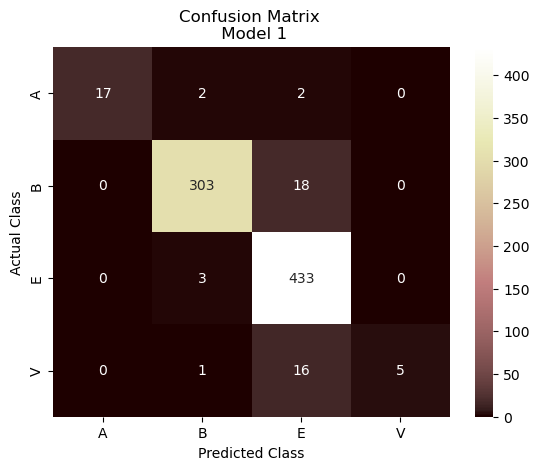

In [82]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

ax = sns.heatmap(cm, annot=True, fmt='g', cmap='pink');
ax.set_title('Confusion Matrix \n Model 1');
ax.set_xlabel('Predicted Class');
ax.set_ylabel('Actual Class');

ax.xaxis.set_ticklabels(['A', 'B', 'E', 'V'])
ax.yaxis.set_ticklabels(['A', 'B', 'E', 'V'])

plt.show()

[[ 17   2   2   0]
 [  0 307  14   0]
 [  0   3 433   0]
 [  0   1   7  14]]


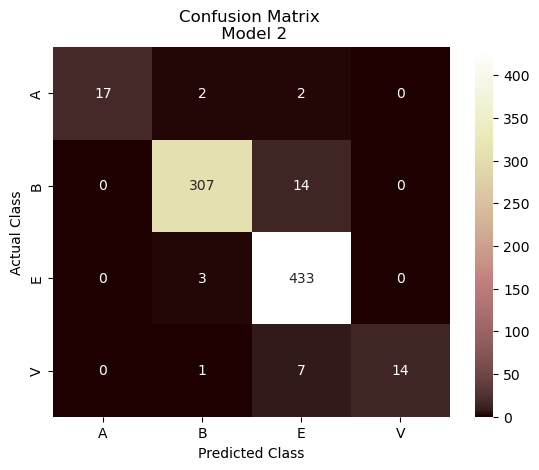

In [83]:
#confusion matrix
cm2 = confusion_matrix(y_test, y_pred2)
print(cm2)

ax2 = sns.heatmap(cm2, annot=True, fmt='g', cmap='pink');
ax2.set_title('Confusion Matrix \n Model 2');
ax2.set_xlabel('Predicted Class');
ax2.set_ylabel('Actual Class');

ax2.xaxis.set_ticklabels(['A', 'B', 'E', 'V'])
ax2.yaxis.set_ticklabels(['A', 'B', 'E', 'V'])

plt.show()

Above we see that the new model has improved its True-Positive rate specifically when predicting the 'V' class.

## Code
Below is my code to predict the test data for kaggle based on my improved model above.

In [84]:
#get prior prob for labels:
def get_nb(y_train):
    total = y_train.count()

    nb_s = y_train.value_counts()
    nb_df = pd.DataFrame(nb_s, index = nb_s.index)
    nb_df = nb_df.rename(columns = {'class' : 'Label_Counts'})

    #add prior prob
    nb_df['Prior_Label'] = nb_df['Label_Counts'] / total
    nb_df['Log_Prior'] = np.log(nb_df['Prior_Label'])
    return nb_df

def get_nb_log2(X_train, y_train):
    count_vect2 = CountVectorizer(stop_words = 'english')
    count_mtx2 = count_vect2.fit_transform(X_train)
    count_array2 = np.array(count_mtx2.todense())
    train_count_df2 = pd.DataFrame(data = count_array2, columns = count_vect2.get_feature_names_out())

    #adding relative labels
    count_df2 = train_count_df2.copy()
    count_df2.insert(0, "Label", y_train)

    #group_by to get the counts grouped by Class
    class_count1 = count_df2.groupby('Label').sum()

    #remove columns identified by numbers
    class_count2 = class_count1.filter(regex = '^[^0-9]+')

    #Laplace smoothing
    class_count2 += 1

    class_count2.sum(axis = 1)

    #converting to conditional probabilities
    class_prob2 = class_count2.div(class_count2.sum(axis = 1), axis = 'index')

    #checking sum of rows == 1
    class_prob2.sum(axis = 1)

    return np.log(class_prob2)

#process text with stop_words
def text_prep2(text_arr):
    tcount_vect = CountVectorizer(stop_words = 'english')
    tcount_mtx = tcount_vect.fit_transform(text_arr)
    tcount_array = np.array(tcount_mtx.todense())
    tcount_df = pd.DataFrame(data = tcount_array, columns = tcount_vect.get_feature_names_out(), index = text_arr.index)
    return tcount_df

#applying model to estimate predictions
def pred_nb(tcount_df, prior, likeli_log):
    y_pred = []

    for row in tcount_df.index:
        test_row = tcount_df.iloc[row].iloc[tcount_df.iloc[row].to_numpy().nonzero()]

        abev = prior['Log_Prior'].copy()

        for a, b, in test_row.items():
            
            if a in likeli_log.columns:
                abev += b * likeli_log[a]

        y_pred.append(abev.idxmax())

    return y_pred



In [85]:

#process new text files
text_test = pd.read_table("tst.csv", sep=",")

#generate predictions
ty_pred2 = pred_nb(text_prep2(text_test['abstract']), get_nb(text_train['class']), get_nb_log2(text_train['abstract'], text_train['class']))

pred_df2 = pd.DataFrame({'class' : ty_pred2}, index = text_test['id'])

#pred_df2.to_csv('tst_out2.csv')

This is the code used to predict the test data with my basic Naive Bayes Classifier.

In [86]:
#build prediction model
def get_nb_log0(X_train, y_train):
    count_vect2 = CountVectorizer()
    count_mtx2 = count_vect2.fit_transform(X_train)
    count_array2 = np.array(count_mtx2.todense())
    train_count_df2 = pd.DataFrame(data = count_array2, columns = count_vect2.get_feature_names_out(), index = X_train.index)

    #adding relative labels
    count_df2 = train_count_df2.copy()
    count_df2.insert(0, "Label", y_train)

    #group_by to get the counts grouped by Class
    class_count1 = count_df2.groupby('Label').sum()

    #remove columns identified by numbers
    class_count2 = class_count1.filter(regex = '^[^0-9]+')

    #Laplace smoothing
    class_count2 += 1

    class_count2.sum(axis = 1)

    #converting to conditional probabilities
    class_prob2 = class_count2.div(class_count2.sum(axis = 1), axis = 'index')

    #checking sum of rows == 1
    class_prob2.sum(axis = 1)

    return np.log(class_prob2)

#process text with stop_words
def text_prep0(text_arr):
    tcount_vect = CountVectorizer()
    tcount_mtx = tcount_vect.fit_transform(text_arr)
    tcount_array = np.array(tcount_mtx.todense())
    tcount_df = pd.DataFrame(data = tcount_array, columns = tcount_vect.get_feature_names_out())
    return tcount_df

#applying model to estimate predictions
def pred_nb(tcount_df, prior, likeli_log):
    y_pred = []

    for row in tcount_df.index:
        test_row = tcount_df.iloc[row].iloc[tcount_df.iloc[row].to_numpy().nonzero()]

        abev = prior['Log_Prior'].copy()

        for a, b, in test_row.items():
            
            if a in likeli_log.columns:
                abev += b * likeli_log[a]

        y_pred.append(abev.idxmax())

    return y_pred

#get prior prob for labels:
def get_nb(y_train):
    total = y_train.count()

    nb_s = y_train.value_counts()
    nb_df = pd.DataFrame(nb_s, index = nb_s.index)
    nb_df = nb_df.rename(columns = {'class' : 'Label_Counts'})

    #add prior prob
    nb_df['Prior_Label'] = nb_df['Label_Counts'] / total
    nb_df['Log_Prior'] = np.log(nb_df['Prior_Label'])
    return nb_df

In [87]:

#process new text files
text_test = pd.read_table("tst.csv", sep=",")

#generate predictions
ty_pred = pred_nb(text_prep0(text_test['abstract']), get_nb(text_train['class']), get_nb_log0(text_train['abstract'], text_train['class']))

pred_df = pd.DataFrame({'class' : ty_pred}, index = text_test['id'])

#pred_df.to_csv('tst_out.csv')